# Tutorial on using the dMRI Microstructure Toolbox

Work in Progress...  
Author: Dr. Rutger Fick  
Starting date : 23-10-2017

In this tutorial we will show the basic usage of the dMRI Microstructure Toolbox.

To generate and fit dMRI data originating from a single voxel:

- Some basics about dMRI acquisition parameters, and what information is needed to use the toolbox.
- How to load, set model parameters, and generate diffusion signals, and fit data using individual biophysical models.
- How to combine biophysical models into a combined "microstructure model".
- How to impose parameter linking between different components in a microstructure model, such as a Tortuosity constraint.
- How to generate and fit data with microstructure models.

Finally, to fit N-dimensional data sets with any model we also explain how to set voxel-dependent initial conditions for the fitting process.

# Loading acquisition parameters and making an acquisition scheme

The first thing to do is to load the parameters of some acquisition scheme. Typically, the b-values and gradient directions, along with the used pulse duration time $\delta$ and pulse separation time $\Delta$ are known. The Microstruktur toolbox uses SI units, so be careful, as bvalues are typically saved in $s/mm^2$, but we need them in $s/m^2$.

As an example we load the acquisition parameters of the WU-MINN Human Connectome Project:

In [1]:
# load the necessary modules
from mipy.signal_models import three_dimensional_models, dispersed_models
from mipy.acquisition_scheme.acquisition_scheme import acquisition_scheme_from_bvalues
from os.path import join
import numpy as np

# the HCP acquisition parameters are saved in the following toolbox path:
acquisition_path = three_dimensional_models.GRADIENT_TABLES_PATH

# we can then load the parameters themselves and convert them to SI units:
bvalues = np.loadtxt(join(acquisition_path, 'bvals_hcp_wu_minn.txt'))  # given in s/mm^2
bvalues = bvalues * 1e6  # now given in SI units as s/m^2
gradient_directions = np.loadtxt(join(acquisition_path, 'bvecs_hcp_wu_minn.txt'))  # on the unit sphere

# The delta and Delta times we know from the HCP documentation in seconds
delta = 0.0106  
Delta = 0.0431 

# The acquisition scheme we use in the toolbox is then simply created as follows:
acq_scheme = acquisition_scheme_from_bvalues(bvalues, gradient_directions, delta, Delta)

From the acquisition scheme, some basic information can be called using the following command:

In [2]:
acq_scheme.print_acquisition_info()

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms]
0           |18        |0               |0                        |10.6       |43.1 
1           |90        |1000            |56                       |10.6       |43.1 
2           |90        |2000            |79                       |10.6       |43.1 
3           |90        |3000            |97                       |10.6       |43.1 


As the summary shows, the function automatically separates the different acquisition shells and detects b0 measurements.  
Other metrics such as qvalues, gradient strengths, diffusion times and the shell_indices can also be explicitly called as follows:

In [3]:
acq_scheme.bvalues;  # bvalues in s/m^2
acq_scheme.gradient_directions;  # gradient directions on the unit sphere
acq_scheme.gradient_strengths;  # the gradient strength in T/m
acq_scheme.qvalues;  # describes the diffusion sensitization in 1/m
acq_scheme.tau;  # diffusion time as Delta - delta / 3. in seconds
acq_scheme.shell_indices;  # index assigned to each shell. 0 is assigned to b0 measurements

If needed, acquisition schemes can also be created from qvalues or gradient strengths by importing acquisition_scheme_from_qvalues or acquisition_scheme_from_gradient_strengths.

# Simulating and fitting data using biophysical models - Model Overview

Now that we have defined an acquisition scheme, it is possible to use the toolbox to simulate and fit data with any one biophysical model - or any combination of biophysical models, comprising a multi-compartment microstructure model. 

Below we first give a brief overview of which models are currently available in the toolbox:

### Cylinder Models

Cylinder models are typically used to describe intra-axonal diffusion, and we provide a more detailed explanation at the [intra-axonal cylinder model tutorial (to be done)](https://github.com/AthenaEPI/microstruktur/blob/master/examples/example_intra_axonal_cylinder_models.ipynb). All cylinder models assume parallel diffusion $\lambda_\parallel$ orientated along $\mu$ is free, but have different approximations for perpendicular diffusion. Briefly, from simplest to more complex approximations, we have:  
- Stick model: Cylinder of radius zero, assumes perpendicular diffusion is zero.
- Soderman model: Cylinder of finite radius $R$, assumes narrow pulses $\delta\rightarrow0$ and restricted perpendicular diffusion $\Delta\gg R^2/D$.
- Callaghan model: Still assumes narrow pulses but accounts for finite pulse separation $\Delta$.
- Van Gelderen / Gaussian Phase model: Accounts for both finite pulse duration $\delta$ and pulse separation $\Delta$.

In [4]:
cylinder_stick = three_dimensional_models.I1Stick()
cylinder_soderman = three_dimensional_models.I2CylinderSodermanApproximation()
cylinder_callaghan = three_dimensional_models.I3CylinderCallaghanApproximation()
cylinder_vangelderen = three_dimensional_models.I4CylinderGaussianPhaseApproximation()

### Gaussian Models

Gaussian models that are typically used to described extra-axonal diffusion, and we provide a more detailed explanation at the [extra-axonal Gaussian model tutorial](https://github.com/AthenaEPI/microstruktur/blob/master/examples/example_extra_axonal_gaussian_models.ipynb). Briefly, we have:  
- Dot model: Compartment in which diffusion is negligble, i.e. diffusion coefficients is zero.
- Ball model: Isotropic Gaussian diffusion with diffusion coefficients $\lambda_{iso}$.
- Zeppelin Model: Axially symmetric Gaussian tensor, oriented along orientation $\mu$ with parallel and perpendicular diffusivity $\lambda_\parallel$ and $\lambda_\perp$.
- Restricted zeppeling model: Axially symmetric Gaussian tensor with time-dependent perpendicular diffusion to account for diffusion restricted in the extra-axonal space between axons. Instead of $\lambda_\perp$, this model has $\lambda_{inf}$ and characteristic coefficient $A$.

In [5]:
gaussian_dot = three_dimensional_models.E2Dot()
gaussian_ball = three_dimensional_models.E3Ball()
gaussian_zeppelin = three_dimensional_models.E4Zeppelin()
gaussian_restricted_zeppelin = three_dimensional_models.E5RestrictedZeppelin()

### Models simulating axonal dispersion

Parametric angular distributions such as the Bingham and Watson are typically used to model axonal dispersion, and we provide a more detailed explanation of these distributions at the [axon dispersion tutorial](https://github.com/AthenaEPI/microstruktur/blob/master/examples/example_watson_bingham.ipynb).

Basically, we can disperse any axially symmetric model (such as a cylinder or zeppelin) using a Watson or Bingham distribution. Using a Watson distribution, along with the standard model parameters (i.e. $\lambda_\parallel$ and $\mu$ for the Stick for example), now concentration parameter $\kappa$ sets the concentration of the Sticks. $\kappa=0$ is a completely isotropic distribution, while $\kappa\rightarrow\infty$ is a Delta function along $\mu$.

The Bingham distribution further generalizes the Watson to also include anistropic dispersion, whose anisotropy and orientation is set using secondary concentration parameter $\beta$ and angle $\psi$.

In [6]:
watson_dispersed_stick = dispersed_models.SD3I1WatsonDispersedStick()
watson_dispersed_callaghan = dispersed_models.SD3I2WatsonDispersedSodermanCylinder()
watson_dispersed_soderman = dispersed_models.SD3I3WatsonDispersedCallaghanCylinder()
watson_dispersed_vangelderen = dispersed_models.SD3I4WatsonDispersedGaussianPhaseCylinder()

In [7]:
bingham_dispersed_stick = dispersed_models.SD2I1BinghamDispersedStick()
bingham_dispersed_callaghan = dispersed_models.SD2I2BinghamDispersedSodermanCylinder()
bingham_dispersed_soderman = dispersed_models.SD2I3BinghamDispersedCallaghanCylinder()
bingham_dispersed_vangelderen = dispersed_models.SD2I4BinghamDispersedGaussianPhaseCylinder()

In [8]:
watson_dispersed_zeppelin = dispersed_models.SD3E4WatsonDispersedZeppelin()
bingham_dispersed_zeppelin = dispersed_models.SD2E4BinghamDispersedZeppelin()

### Models simulating axon diameter distributions

To simulate axon diameter distributions Assaf et al. (2008) proposed to use Gamma distributed cylinders, using shape and scale parameters $\alpha$ and $\beta$. We have these Gamma distributions for all three cylinder models with finite cylinder radii.

In [9]:
gamma_distributed_soderman = dispersed_models.DD1I2GammaDistributedSodermanCylinder()
gamma_distributed_callaghan = dispersed_models.DD1I3GammaDistributedCallaghanCylinder()
gamma_distributed_vangelderen = dispersed_models.DD1I4GammaDistributedGaussianPhaseCylinder()

### Models Based on the Spherical Mean

Finally, we also have spherical mean models that don't fit the 3D DWI signal, but only the 1D spherical mean signal over b-value.
- Spherical mean of the Stick model.
- Spherical mean of the Zeppelin model.
- Spherical mean of the restricted Zeppelin model. (unpublished as far as I know)

In [10]:
spherical_mean_stick = three_dimensional_models.I1StickSphericalMean()
spherical_mean_zeppelin = three_dimensional_models.E4ZeppelinSphericalMean()
spherical_mean_restricted_zeppelin = three_dimensional_models.E5RestrictedZeppelinSphericalMean()

# Example 1: Simulating and fitting data using only Stick model

As the simplest example we will simulate data using the Stick model, and then use the same Stick model to fit the signal again. As we did above, we first instantiate the model we need.

NOTE: this example is EXACTLY the same with any of the other models, you only need to change the model and appropriate input parameters.

In [11]:
cylinder_stick = three_dimensional_models.I1Stick()

To find more information on the model parameters check its help function. We can also print the parameter cardinality to figure out the parameter names, and their input format.

In [12]:
cylinder_stick.parameter_cardinality

OrderedDict([('lambda_par', 1), ('mu', 2)])

As the function shows, we need to give the Stick one parallel diffusivity as lambda_par, and its orientation mu as angles on the sphere [theta, phi].  
For the example we align the Stick with some angle and give it a diffusivity of 1e-9 m^2/s. We obtain the right ordering for the input of the function by using the parameters_to_parameter_vector() function:

In [13]:
mu = (np.pi / 2., np.pi / 2.)
lambda_par = 1e-9
parameter_vector = cylinder_stick.parameters_to_parameter_vector(
    lambda_par=lambda_par, mu=mu)

A diffusion signal, for the given model parameters and our previously made acquisition scheme is then simply generated as follows:

In [14]:
E = cylinder_stick.simulate_signal(acq_scheme, parameter_vector)

Let's assume this signal is now unknown, and we want to fit the Stick model to this signal to find best fitting model parameters. Using the same procedure as before, we now set an initial condition for the same parameters from which we start the optimization.

In [15]:
initial_mu = np.random.rand(2)
initial_lambda_par = np.random.rand() * 1e-9
x0 = cylinder_stick.parameters_to_parameter_vector(
    lambda_par=initial_lambda_par, mu=initial_mu)

Using the data, acquisition scheme and initial guess, we fit the model using the following one-liner. We can see the correct model parameters are obtained.

In [16]:
res = cylinder_stick.fit(E, acq_scheme, x0)
print 'Initial guess:   ', x0
print 'Optimized result:', res
print 'Ground truth:    ', parameter_vector

Initial guess:    [  7.44236915e-11   4.60920209e-01   6.13735057e-01]
Optimized result: [  9.99988497e-10   1.57080101e+00   1.57080387e+00]
Ground truth:     [  1.00000000e-09   1.57079633e+00   1.57079633e+00]


The names of the parameters can again be obtained using parameter_vector_to_parameters.

In [17]:
cylinder_stick.parameter_vector_to_parameters(res)

{'lambda_par': array([  9.99988497e-10]),
 'mu': array([ 1.57080101,  1.57080387])}

# Example 2: Simulating and fitting data using Ball & Stick model

Now to make our first multi-compartment Microstructure model! Don't worry, we start with a simple Ball & Stick model, and the procedure will be very simple and similar as before. First, we instantiate the models we want:

In [18]:
stick = three_dimensional_models.I1Stick()
ball = three_dimensional_models.E3Ball()

Next, we combine them into one model using PartialVolumeCombinedMicrostructureModel.  
Our new model will now be $E = vf * E_{Ball} + (1 - vf) * E_{Stick}$ where $vf$ is the volume fraction between zero and one.

In [19]:
ball_and_stick = (
    three_dimensional_models.PartialVolumeCombinedMicrostrukturModel(
        models=[ball, stick]))

That it! We can again figure out the required parameter names using parameter_cardinality. As we are combining models, the parameter names now have the corresponding model prepended to it.

In [21]:
ball_and_stick.parameter_cardinality

OrderedDict([('I1Stick_1_lambda_par', 1),
             ('E3Ball_1_lambda_iso', 1),
             ('I1Stick_1_mu', 2),
             ('partial_volume_0', 1)])

It can be seen that now 'partial_volume_0' also appears. Note that the ordering in which you give models matters for the significance of the partial_volume_0! The procedure to simulate data is now the same as before:

In [31]:
mu = (np.pi / 2., np.pi / 2.)
lambda_par = 1e-9
lambda_iso = .6e-9
partial_volume = 0.5

parameter_vector = ball_and_stick.parameters_to_parameter_vector(
    I1Stick_1_lambda_par=lambda_par,
    E3Ball_1_lambda_iso=lambda_iso,
    I1Stick_1_mu=mu,
    partial_volume_0=partial_volume
)

E = ball_and_stick.simulate_signal(
    acq_scheme, parameter_vector)

Fitting the data is also the same as before:

In [36]:
initial_mu = (np.pi / 4., np.pi / 4.)
initial_lambda_par = 1.4e-9
intial_lambda_iso = .2e-9
intial_partial_volume = .3

x0 = ball_and_stick.parameters_to_parameter_vector(
    I1Stick_1_lambda_par=initial_lambda_par,
    E3Ball_1_lambda_iso=intial_lambda_iso,
    I1Stick_1_mu=initial_mu,
    partial_volume_0=intial_partial_volume
)
res = ball_and_stick.fit(E, acq_scheme, x0)

In [39]:
# the optimized results
ball_and_stick.parameter_vector_to_parameters(res)

{'E3Ball_1_lambda_iso': array([  5.99978175e-10]),
 'I1Stick_1_lambda_par': array([  1.00005459e-09]),
 'I1Stick_1_mu': array([ 1.57080643,  1.57081038]),
 'partial_volume_0': array([ 0.49998818])}

In [40]:
# and the ground truth correspond
ball_and_stick.parameter_vector_to_parameters(parameter_vector)

{'E3Ball_1_lambda_iso': array([  6.00000000e-10]),
 'I1Stick_1_lambda_par': array([  1.00000000e-09]),
 'I1Stick_1_mu': array([ 1.57079633,  1.57079633]),
 'partial_volume_0': array([ 0.5])}

# Example 3: Imposing parameter links - Tortuosity and Equality

In Microstructure Imaging, microstructure models like NODDI represent the combined diffusion in the intra- and extra-axonal space as a dispersed stick and a dispersed zeppelin. NODDI further imposes two constraints on the parameters of the model:
- Certain parameters are the same between the zeppelin and the stick, such as the orientation $\mu$, parallel diffusivity $\lambda_\parallel$, and concentration $\kappa$.
- The model imposes a Tortuosity constraint, such that $\lambda_\perp=(1-vf)\lambda_\parallel$.

The microstructure toolbox allows us to straightforwardly impose such constraints on a microstructure model.  First we instantiate the required models.

In [49]:
watson_stick = dispersed_models.SD3I1WatsonDispersedStick()
watson_zeppelin = dispersed_models.SD3E4WatsonDispersedZeppelin()

Just combining these two models results in a model with a lot of parameters, which will probably be very hard to optimize to a global optimum.

In [50]:
dispersed_stick_and_zeppelin = (
    three_dimensional_models.PartialVolumeCombinedMicrostrukturModel(
        models=[watson_stick, watson_zeppelin]))
dispersed_stick_and_zeppelin.parameter_cardinality

OrderedDict([('SD3E4WatsonDispersedZeppelin_1_lambda_perp', 1),
             ('SD3I1WatsonDispersedStick_1_mu', 2),
             ('SD3I1WatsonDispersedStick_1_kappa', 1),
             ('SD3E4WatsonDispersedZeppelin_1_mu', 2),
             ('SD3I1WatsonDispersedStick_1_lambda_par', 1),
             ('SD3E4WatsonDispersedZeppelin_1_kappa', 1),
             ('SD3E4WatsonDispersedZeppelin_1_lambda_par', 1),
             ('partial_volume_0', 1)])

We can impose the required parameter constraints by making a parameter linking list. Such a list has the general shape as follows:  
[(model1, parameter_to_be_linked, linking_function, [(model2, link_function_input_parameter)])]

For example, to make the orientation $\mu$ the same between the Stick and Zeppelin, the linking list would look like this:  
[(watson_zeppelin, 'mu',  parameter_equality, [(watson_stick, 'mu')])]

To add a tortuosity constraint, the linking list would look as follows:  
[(watson_zeppelin, 'lambda_perp', T1_tortuosity, [(None, 'partial_volume_0'), (watson_stick, 'lambda_par')])] 

Notice that T1_tortuosity takes 2 input parameters, namely the volume fraction and parallel diffusivity. We can impose a list of links/constraints by simply growing the list:

In [53]:
from mipy.signal_models.utils import (
    T1_tortuosity, parameter_equality)

parameter_links_dispersed_stick_and_tortuous_zeppelin = [
    (watson_zeppelin, 'lambda_perp', T1_tortuosity,
     [(None, 'partial_volume_0'), (watson_stick, 'lambda_par')]
    ), 
    (watson_zeppelin, 'lambda_par', parameter_equality,
     [(watson_stick, 'lambda_par')]
    ),
    (watson_zeppelin, 'mu',  parameter_equality, 
     [(watson_stick, 'mu')]
    ),
    (watson_zeppelin, 'kappa',  parameter_equality, 
     [(watson_stick, 'kappa')]
    ),
]

Now that the parameter linking is prepared, we can simply give them as input in PartialVolumeCombinedMicrostructureModel. Notice that parameter_cardinality now only shows non-linked (so the to-be-optimized) parameters. The remaining parameters are linked internally.

In [54]:
dispersed_stick_and_tortuous_zeppelin = (
    three_dimensional_models.PartialVolumeCombinedMicrostrukturModel(
        models=[watson_stick, watson_zeppelin],
        parameter_links=parameter_links_dispersed_stick_and_tortuous_zeppelin)
)
dispersed_stick_and_tortuous_zeppelin.parameter_cardinality

OrderedDict([('SD3I1WatsonDispersedStick_1_mu', 2),
             ('SD3I1WatsonDispersedStick_1_kappa', 1),
             ('SD3I1WatsonDispersedStick_1_lambda_par', 1),
             ('partial_volume_0', 1)])

# Example 4: Simulating and fitting multiple voxels with varying initial conditions

For real applications, we may need to simulate data with many different initial conditions, or fit a real dataset where we want to give a voxel-dependent initial condition to avoid local minima. The toolbox allows you to do both these things by generating a multi-dimensional parameter_vector.

As an example, we will generate a simple Ball & Stick model.

In [55]:
stick = three_dimensional_models.I1Stick()
ball = three_dimensional_models.E3Ball()
ball_and_stick = (
    three_dimensional_models.PartialVolumeCombinedMicrostrukturModel(
        models=[ball, stick]))

Now say we want to simulate the signal in each voxel to have the same lambdas and partial_volume, but varying 10x10 grid of $\mu$. This can be done by giving parameters_to_parameter vector just the single value you want for the lambdas and partial_volume, but the mu as a 10x10x2 array.

In [65]:
lambda_par = np.random.rand() * 1e-9
lambda_iso = gt_lambda_par / 2.
partial_volume = 0.4
mu_array = np.random.rand(10, 10, 2) * 2.

gt_parameter_vector = (
    ball_and_stick.parameters_to_parameter_vector(
        I1Stick_1_lambda_par=lambda_par,
        E3Ball_1_lambda_iso=lambda_iso,
        I1Stick_1_mu=mu_array,
        partial_volume_0=partial_volume)
)

#notice that the entire parameter array is now 10x10x5
print gt_parameter_vector.shape

(10, 10, 5)


In [67]:
# the data can now be generated exactly as before.
E_array = ball_and_stick.simulate_signal(acq_scheme, gt_parameter_vector)
print E_array.shape

(10, 10, 288)


Finally, we can fit the data with either a static initial condition or a voxel-varying one, where we will use the ground truth as an example.

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline  

single_parameter_vector = (
    ball_and_stick.parameters_to_parameter_vector(
        I1Stick_1_lambda_par=lambda_par,
        E3Ball_1_lambda_iso=lambda_iso,
        I1Stick_1_mu=(0, 0),
        partial_volume_0=partial_volume)
)
# I'm giving a either a single or voxel-dependent initial condition with gt_mu_array
res_single_x0 = ball_and_stick.fit(E_array, acq_scheme, single_parameter_vector)
res_voxel_dependent_x0 = ball_and_stick.fit(E_array, acq_scheme, gt_parameter_vector)

To illustrate how important it is to give a good initial condition to the model, we plot the percentual error of the estimated model parameters compared to the ground truth:

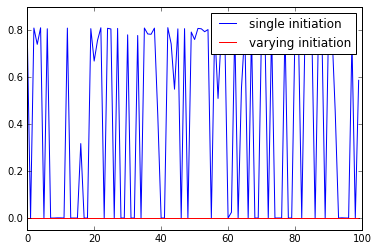

In [96]:
percentual_error_single = np.mean(
    ((abs(gt_parameter_vector - res_single_x0)) / gt_parameter_vector), axis=-1)
percentual_error_varying = np.mean(
    ((abs(gt_parameter_vector - res_voxel_dependent_x0)) / gt_parameter_vector), axis=-1)

plt.plot(percentual_error_single.ravel(), c='b', label='single initiation')
plt.ylim(-.05, .9)
plt.plot(percentual_error_varying.ravel(), c='r', label='varying initiation')
plt.legend()

The results using varying initial condition (using the ground truth in this case) unsurprisingly always results in the optimal solution, and using the same initiation often results in a local minimum. This underscores that care must be taken when applying microstructure models to real data.

# Example 5: Fitting real data using a custom microstructure model